# Preparation

This project aims on using Deep Learning with Kullback-Leibler Divergence. Some basic packages are required for this project. The aim of the following chunk is to install required packages such as `lifelines`, `sklearn-pandas` and `torchtuples`. Note that `pycox` is built based on `torchtuples`.

---

`pycox` should be pre-installed and removed into the google drive since we need to modify part of the code in this package for our model. However in the tutorial, we can actually predefine our loss function outside the package, so this part need to be updated probably.


In [1]:
!pwd
!pip install lifelines
! pip install sklearn-pandas
! pip install torchtuples
# ! pip install statsmodels
! pip install statsmodels --upgrade
# ! pip install pycox

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 5.1 MB/s 
     |████████████████████████████████| 68 kB 7.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=bc353aad1f44210e8c25757640f9a32e2af061719f53848bffe0affb178a6495
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is inco

`pycox` is pre-installed in /content/drive/MyDrive/pycox, before that we need to track the data in google drive.

In [2]:
from google.colab import drive

drive.mount("/content/drive")

%cd "/content/drive/MyDrive/pycox"
# %pwd
# from pycox.models import LogisticHazard

Mounted at /content/drive
/content/drive/MyDrive/pycox


In [3]:
import os
import sys

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch # For building the networks 
import torchtuples as tt # Some useful functions

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
from random import sample
from pycox.datasets import metabric
from pycox.datasets import support
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

import torch
import torchtuples as tt

from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 

# MNIST is part of torchvision
from torchvision import datasets, transforms

from pycox.utils import kaplan_meier

In [4]:
np.random.seed(1234)
_ = torch.manual_seed(1234)

If you have mounted the data rightly, you should print out the list for files in given folder. For example, this will print out all files in `/content/drive/My Drive/Kevin He`

In [5]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A4 folder, then "2022WI/A4"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Kevin He"
GOOGLE_DRIVE_PATH = os.path.join("/content/drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['Deep Learning with KL Divergence Simulation 3: Tutorial.ipynb', 'local_data.csv', 'prior_data.csv', 'local_data_2.csv', 'local_data_3.csv', 'prior_data_subset.csv', 'prior_data_subset_2.csv', 'prior_data_subset_3.csv', 'R-code.ipynb', 'local_data_together.csv', 'Untitled', 'Deep Learning with KL Divergence Non-linear Visualization.ipynb', 'Deep Learning with KL Divergence Simulation Image Data.ipynb', 'Deep Learning with KL Divergence.ipynb', 'Deep Learning with KL Divergence Real Data.ipynb', 'prior_data_subset_4.csv', 'Deep Learning with KL Divergence Simulation 1: Tutorial', 'Deep Learning with KL Divergence Simulation Non-linear-prop.ipynb', 'Deep Learning with KL Divergence Simulation 2-1: Tutorial.ipynb', 'Deep Learning with KL-divergence Real Data: Tutorial.ipynb']


# Find Image Data

In this experiment, we will use image data as the features to generate the survival function, MNIST is one handwritting-digit dataset with 60000 training data and 10000 test data. The digit of the image will be used as one hyperparameter $\alpha$ and event_times will be generated by an exponential function $\exp(\alpha)$. We use $700$ as the maximum time for observation, which means patients with event_time > 700 will be marked as censored data. 

Below is one visualization of the image data. The digit is 5.

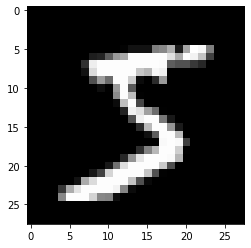

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))]
)
mnist_train = datasets.MNIST('.', train=True, download=True,
                             transform=transform)
mnist_test = datasets.MNIST('.', train=False, transform=transform)
_ = plt.imshow(mnist_train[0][0][0].numpy(), cmap='gray')

`sim_event_times` is the function for generating event time and status. Larger digit means lower betas. `status = 0` means censored. `tt.tuplefy` will generate a tuple with time and status as two elements.

In [7]:
def sim_event_times(mnist, max_time=365):
    digits = mnist.targets.numpy()
    betas = 365 * np.exp(-0.6 * digits) / np.log(1.2)
    event_times = np.random.exponential(betas)
    censored = event_times > max_time
    event_times[censored] = max_time
    return tt.tuplefy(event_times, ~censored)

In [8]:
sim_train = sim_event_times(mnist_train)
sim_test = sim_event_times(mnist_test)

In [9]:
sim_train

(array([ 21.19004682, 365.        , 104.56743096, ..., 121.80432849,
          2.50843078,  13.8114342 ]),
 array([ True, False,  True, ...,  True,  True,  True]))

In [10]:
sim_test

(array([ 10.42829987, 365.        , 365.        , ..., 191.88540975,
         11.6321451 ,  25.84357732]),
 array([ True, False, False, ...,  True,  True,  True]))

# Simulate Half of The Data

Due to the time cost of CNN, we will only sample out half of the training data (30000 in total). We will store the 30000 images in `img` with size $N \times 1 \times 28 \times 28$. 

In [11]:
from random import sample

list1 = [i for i in range(60000)]
index = sample(list1, 30000)

In [12]:
img = [mnist_train[i][0] for i in index]
img = torch.stack(img)
img.shape

torch.Size([30000, 1, 28, 28])

In [13]:
sim_train_subset = (sim_train[0][index], sim_train[1][index])

We will transform the event time to discrete version. `labtrans.cuts` can see the boundaries for each time interval.

In [14]:
labtrans = LogisticHazard.label_transform(20)
target_train = labtrans.fit_transform(*sim_train_subset)

labtrans.cuts

array([  0.        ,  19.21052632,  38.42105263,  57.63157895,
        76.84210526,  96.05263158, 115.26315789, 134.47368421,
       153.68421053, 172.89473684, 192.10526316, 211.31578947,
       230.52631579, 249.73684211, 268.94736842, 288.15789474,
       307.36842105, 326.57894737, 345.78947368, 365.        ])

In [15]:
target_train

(array([ 2, 19, 19, ...,  1,  1,  5]),
 array([1., 0., 0., ..., 1., 1., 1.], dtype=float32))

In summary, `img` is used for storing images for training and `target_train` is the event time and status.

# Prior Model Training

Similarly, we select 90% of the data (`ratio = 0.9`) and we select the corresponding prior and local information by indexing.

In [130]:
ratio = 0.9

list1 = [i for i in range(30000)]
index_prior = sample(list1, int(30000 * ratio))
index_local = [i for i in list1 if i not in index_prior]

img_prior = [img[i] for i in index_prior]
img_prior = torch.stack(img_prior)

img_local = [img[i] for i in index_local]
img_local = torch.stack(img_local)

target_prior = (target_train[0][index_prior], target_train[1][index_prior])
target_local = (target_train[0][index_local], target_train[1][index_local])
# sim_prior = (sim_train_subset[0][index_prior], sim_train_subset[1][index_prior])
# sim_local = (sim_train_subset[0][index_local], sim_train_subset[1][index_local])

In [131]:
list1 = [i for i in range(int(30000 * ratio))]
index_prior_train = sample(list1, int(30000 * ratio * 0.8))
index_prior_val = [i for i in list1 if i not in index_prior_train]

img_prior_train = [img_prior[i] for i in index_prior_train]
img_prior_train = torch.stack(img_prior_train)

img_prior_val = [img_prior[i] for i in index_prior_val]
img_prior_val = torch.stack(img_prior_val)

target_prior_train = (target_prior[0][index_prior_train], target_prior[1][index_prior_train])
target_prior_val = (target_prior[0][index_prior_val], target_prior[1][index_prior_val])

We use `MnistSimDatasetBatch` to create a class for transforming data into dataloader, which will be used for further model training.

In [132]:
class MnistSimDatasetBatch(Dataset):
    def __init__(self, mnist_dataset, time, event):
        self.mnist_dataset = mnist_dataset
        self.time, self.event = tt.tuplefy(time, event).to_tensor()

    def __len__(self):
        return len(self.time)

    def __getitem__(self, index):
        if not hasattr(index, '__iter__'):
            index = [index]
        img = [self.mnist_dataset[i] for i in index]
        img = torch.stack(img)
        return tt.tuplefy(img, (self.time[index], self.event[index]))

data_prior = MnistSimDatasetBatch(img_prior, *target_prior)
# data_local = MnistSimDatasetBatch(img_local, *target_local)
data_prior_train = MnistSimDatasetBatch(img_prior_train, *target_prior_train)
data_prior_val = MnistSimDatasetBatch(img_prior_val, *target_prior_val)

We also use `tt.data.DataLoaderBatch` to do batch training.

In [133]:
batch_size = 64

dl_prior = tt.data.DataLoaderBatch(data_prior, batch_size, shuffle=True)
# dl_local = tt.data.DataLoaderBatch(data_local, batch_size, shuffle=True)

dl_prior_train = tt.data.DataLoaderBatch(data_prior_train, batch_size, shuffle=True)
dl_prior_val = tt.data.DataLoaderBatch(data_prior_val, batch_size, shuffle=False)

next(iter(dl_prior_train)).shapes()

(torch.Size([64, 1, 28, 28]), (torch.Size([64]), torch.Size([64])))

In [134]:
class Net(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1)
        self.max_pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 16, 5, 1)
        self.glob_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, out_features)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.glob_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

`net` can show the details of the model.

In [135]:
net = Net(labtrans.out_features)
net

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (glob_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=20, bias=True)
)

In [136]:
model = LogisticHazard(net, tt.optim.Adam(0.01))

Here we train a model using prior data, note that the final val_loss should be around `1.8`. 

In [137]:
callbacks = [tt.cb.EarlyStopping(patience=5)]
epochs = 100
verbose = True
log = model.fit_dataloader(dl_prior_train, epochs, callbacks, verbose, val_dataloader=dl_prior_val)

0:	[0s / 0s],		train_loss: 2.3457,	val_loss: 2.2697
1:	[0s / 1s],		train_loss: 2.0903,	val_loss: 2.0315
2:	[0s / 1s],		train_loss: 1.9794,	val_loss: 1.9879
3:	[0s / 2s],		train_loss: 1.9261,	val_loss: 1.9201
4:	[0s / 2s],		train_loss: 1.9137,	val_loss: 1.8926
5:	[0s / 3s],		train_loss: 1.8712,	val_loss: 1.8893
6:	[0s / 3s],		train_loss: 1.8652,	val_loss: 1.8565
7:	[0s / 4s],		train_loss: 1.8430,	val_loss: 1.8955
8:	[0s / 5s],		train_loss: 1.8395,	val_loss: 1.8922
9:	[0s / 5s],		train_loss: 1.8220,	val_loss: 1.8404
10:	[0s / 6s],		train_loss: 1.8099,	val_loss: 1.8618
11:	[0s / 6s],		train_loss: 1.8093,	val_loss: 1.8677
12:	[0s / 7s],		train_loss: 1.7975,	val_loss: 1.8884
13:	[0s / 7s],		train_loss: 1.7931,	val_loss: 1.8463
14:	[0s / 8s],		train_loss: 1.7846,	val_loss: 1.8358
15:	[0s / 8s],		train_loss: 1.7835,	val_loss: 1.8308
16:	[0s / 9s],		train_loss: 1.7830,	val_loss: 1.8318
17:	[0s / 9s],		train_loss: 1.7821,	val_loss: 1.8534
18:	[0s / 10s],		train_loss: 1.7767,	val_loss: 1.8358
19

In [138]:
class MnistSimInput(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        img = self.mnist_dataset[index]
        return img

data_local_test = MnistSimInput(img_prior_val)
dl_local_test = DataLoader(data_local_test, batch_size, shuffle=False)

`interpolate` is used for generalizing our data trained for discrete time model. This is used for computing integrated brier score.

In [139]:
surv = model.interpolate(10).predict_surv_df(dl_local_test)
ev = EvalSurv(surv, *target_prior_val, 'km')
ev.concordance_td("antolini")

/usr/local/lib/python3.7/dist-packages/torchtuples/base.py:484: UserWarning: The input from the dataloader is different from
                        the 'input' during trainig. The shapes are different.
  the 'input' during trainig. The shapes are different."""


0.8268961694692692

In [140]:
time_grid = np.linspace(0, sim_test[0].max())
ev.integrated_brier_score(time_grid)

0.12174032639367117

# Apply Prior Model to Local

In [141]:
list1 = [i for i in range(int(30000 * (1 - ratio)))]
index_local_train = sample(list1, int(30000 * (1 - ratio) * 0.8))
index_local_test = [i for i in list1 if i not in index_local_train]

list2 = [i for i in range(int(30000 * (1 - ratio) * 0.8))]
index_temp = sample(list2, int(30000 * (1 - ratio) * 0.8 * 0.8))
index_local_val = [index_local_train[i] for i in list2 if i not in index_temp]
index_local_train = [index_local_train[i] for i in list2 if i in index_temp]

img_local_train = [img_local[i] for i in index_local_train]
img_local_train = torch.stack(img_local_train)

img_local_val = [img_local[i] for i in index_local_val]
img_local_val = torch.stack(img_local_val)

img_local_test = [img_local[i] for i in index_local_test]
img_local_test = torch.stack(img_local_test)

In [142]:
target_local_train = (target_local[0][index_local_train], target_local[1][index_local_train])
target_local_val = (target_local[0][index_local_val], target_local[1][index_local_val])
target_local_test = (target_local[0][index_local_test], target_local[1][index_local_test])

In [143]:
prior_info_train = model.predict_hazard(img_local_train)
prior_info_val = model.predict_hazard(img_local_val)

time = target_local[0]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 21))
np.put_along_axis(zeros, time, np.array(target_local[1]).reshape(-1, 1), axis=1)
zeros = zeros[:, :-1]

zeros_train = zeros[index_local_train]
zeros_val = zeros[index_local_val]

eta = 100
combined_info_train = (torch.Tensor(zeros_train).to("cuda") + eta * prior_info_train) / (1 + eta)
combined_info_val = (torch.Tensor(zeros_val).to("cuda") + eta * prior_info_val) / (1 + eta)


/usr/local/lib/python3.7/dist-packages/torchtuples/base.py:484: UserWarning: The input from the dataloader is different from
                        the 'input' during trainig. The shapes are different.
  the 'input' during trainig. The shapes are different."""


In [147]:
target_local_train_new = (combined_info_train, *target_local_train)
target_local_val_new = (combined_info_val, *target_local_val)

In [231]:
class MnistSimDatasetBatch(Dataset):
    def __init__(self, mnist_dataset, combined_info, time, event):
        self.mnist_dataset = mnist_dataset
        self.time, self.event = tt.tuplefy(time, event).to_tensor()
        self.combined_info = combined_info

    def __len__(self):
        return len(self.time)

    def __getitem__(self, index):
        if not hasattr(index, '__iter__'):
            index = [index]
        img = [self.mnist_dataset[i] for i in index]
        img = torch.stack(img)
        return tt.tuplefy(img, (self.combined_info[index], self.time[index], self.event[index]))

data_local_train = MnistSimDatasetBatch(img_local_train, *target_local_train_new)
data_local_val = MnistSimDatasetBatch(img_local_val, *target_local_val_new)
# data_local_test = MnistSimDatasetBatch(img_local, *target_local_test)

In [232]:
batch_size = 32

dl_local_train = tt.data.DataLoaderBatch(data_local_train, batch_size, shuffle=True)
dl_local_val = tt.data.DataLoaderBatch(data_local_val, batch_size, shuffle=False)
# dl_local_test = tt.data.DataLoaderBatch(data_local_test, batch_size, shuffle=True)

In [233]:
class Net(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1)
        self.max_pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 16, 5, 1)
        self.glob_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, out_features)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.glob_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [234]:
net = Net(labtrans.out_features)
net

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (glob_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=20, bias=True)
)

In [235]:
model = LogisticHazard(net, tt.optim.Adam(0.005), duration_index=labtrans.cuts, loss = "option")

1


In [236]:
callbacks = [tt.cb.EarlyStopping(patience=5)]
epochs = 50
verbose = True
log = model.fit_dataloader(dl_local_train, epochs, callbacks, verbose, val_dataloader=dl_local_val)

0:	[0s / 0s],		train_loss: 3.5945,	val_loss: 2.4057
1:	[0s / 0s],		train_loss: 2.3252,	val_loss: 2.2704
2:	[0s / 0s],		train_loss: 2.2767,	val_loss: 2.2520
3:	[0s / 0s],		train_loss: 2.2687,	val_loss: 2.2670
4:	[0s / 0s],		train_loss: 2.2655,	val_loss: 2.2649
5:	[0s / 0s],		train_loss: 2.2758,	val_loss: 2.2855
6:	[0s / 0s],		train_loss: 2.2650,	val_loss: 2.2402
7:	[0s / 0s],		train_loss: 2.2406,	val_loss: 2.2338
8:	[0s / 0s],		train_loss: 2.2157,	val_loss: 2.2031
9:	[0s / 1s],		train_loss: 2.1849,	val_loss: 2.1480
10:	[0s / 1s],		train_loss: 2.1414,	val_loss: 2.1245
11:	[0s / 1s],		train_loss: 2.1091,	val_loss: 2.0733
12:	[0s / 1s],		train_loss: 2.1096,	val_loss: 2.1204
13:	[0s / 1s],		train_loss: 2.0785,	val_loss: 2.0477
14:	[0s / 1s],		train_loss: 2.0643,	val_loss: 2.0784
15:	[0s / 1s],		train_loss: 2.0604,	val_loss: 2.0475
16:	[0s / 1s],		train_loss: 2.0358,	val_loss: 2.0203
17:	[0s / 1s],		train_loss: 2.0389,	val_loss: 2.0513
18:	[0s / 1s],		train_loss: 2.0456,	val_loss: 2.0329
19:

In [220]:
class MnistSimDatasetBatch(Dataset):
      def __init__(self, mnist_dataset, time, event):
          self.mnist_dataset = mnist_dataset
          self.time, self.event = tt.tuplefy(time, event).to_tensor()

      def __len__(self):
          return len(self.time)

      def __getitem__(self, index):
          if not hasattr(index, '__iter__'):
              index = [index]
          img = [self.mnist_dataset[i] for i in index]
          img = torch.stack(img)
          return tt.tuplefy(img, (self.time[index], self.event[index]))

data_local_train = MnistSimDatasetBatch(img_local_train, *target_local_train)
data_local_val = MnistSimDatasetBatch(img_local_val, *target_local_val)
# data_local_test = MnistSimDatasetBatch(img_local, *target_local_test)

batch_size = 32

dl_local_train = tt.data.DataLoaderBatch(data_local_train, batch_size, shuffle=True)
dl_local_val = tt.data.DataLoaderBatch(data_local_val, batch_size, shuffle=False)

In [221]:
model = LogisticHazard(net, tt.optim.Adam(0.01))

In [222]:
callbacks = [tt.cb.EarlyStopping(patience=20)]
epochs = 50
verbose = True
log = model.fit_dataloader(dl_local_train, epochs, callbacks, verbose, val_dataloader=dl_local_val)

0:	[1s / 1s],		train_loss: 2.2350,	val_loss: 2.2213
1:	[1s / 2s],		train_loss: 2.1016,	val_loss: 2.0505
2:	[1s / 3s],		train_loss: 2.0083,	val_loss: 1.9860
3:	[1s / 4s],		train_loss: 1.9739,	val_loss: 1.9684
4:	[1s / 5s],		train_loss: 1.9579,	val_loss: 1.9511
5:	[1s / 6s],		train_loss: 1.9450,	val_loss: 1.9450
6:	[1s / 7s],		train_loss: 1.9291,	val_loss: 1.9181
7:	[1s / 9s],		train_loss: 1.9138,	val_loss: 1.9319
8:	[1s / 10s],		train_loss: 1.9001,	val_loss: 1.8947
9:	[1s / 11s],		train_loss: 1.8899,	val_loss: 1.8888
10:	[1s / 12s],		train_loss: 1.8894,	val_loss: 1.8892
11:	[1s / 14s],		train_loss: 1.8761,	val_loss: 1.8891
12:	[1s / 15s],		train_loss: 1.8787,	val_loss: 1.9089
13:	[1s / 16s],		train_loss: 1.8735,	val_loss: 1.9034
14:	[1s / 17s],		train_loss: 1.8705,	val_loss: 1.8868
15:	[1s / 19s],		train_loss: 1.8697,	val_loss: 1.8783
16:	[1s / 20s],		train_loss: 1.8642,	val_loss: 1.8971
17:	[1s / 21s],		train_loss: 1.8642,	val_loss: 1.8863
18:	[1s / 22s],		train_loss: 1.8553,	val_loss:

KeyboardInterrupt: ignored

In [157]:
class MnistSimInput(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        img = self.mnist_dataset[index]
        return img

data_local_test = MnistSimInput(img_local_test)
dl_local_test = DataLoader(data_local_test, batch_size, shuffle=False)

next(iter(dl_local_test)).shape

torch.Size([32, 1, 28, 28])

In [237]:
surv = model.interpolate(20).predict_surv_df(dl_local_test)
ev = EvalSurv(surv, *target_local_test, 'km')
ev.concordance_td("antolini")

/usr/local/lib/python3.7/dist-packages/torchtuples/base.py:484: UserWarning: The input from the dataloader is different from
                        the 'input' during trainig. The shapes are different.
  the 'input' during trainig. The shapes are different."""


0.7587042082954889

In [238]:
surv

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0.000000,0.999751,0.997636,0.999853,0.999462,0.997338,0.999825,0.999405,0.999207,0.999958,0.999711,...,0.999742,0.999493,0.999850,0.998726,0.999573,0.996446,0.994760,0.999039,0.999793,0.999848
0.960526,0.984436,0.990663,0.965793,0.998393,0.992378,0.969714,0.993629,0.994352,0.963036,0.998011,...,0.995439,0.994532,0.996768,0.995383,0.996567,0.986823,0.984945,0.988861,0.995661,0.975855
1.921053,0.969121,0.983689,0.931733,0.997325,0.987418,0.939603,0.987854,0.989498,0.926114,0.996310,...,0.991135,0.989570,0.993686,0.992040,0.993560,0.977201,0.975130,0.978683,0.991529,0.951861
2.881579,0.953806,0.976716,0.897673,0.996256,0.982459,0.909491,0.982078,0.984644,0.889192,0.994610,...,0.986832,0.984608,0.990603,0.988697,0.990554,0.967579,0.965314,0.968506,0.987396,0.927868
3.842105,0.938491,0.969743,0.863613,0.995188,0.977499,0.879380,0.976303,0.979790,0.852270,0.992909,...,0.982528,0.979646,0.987521,0.985355,0.987548,0.957956,0.955499,0.958328,0.983265,0.903875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361.157895,0.133584,0.203338,0.005986,0.585526,0.241694,0.013295,0.355182,0.352951,0.004731,0.588772,...,0.469660,0.388470,0.571095,0.364191,0.484148,0.129456,0.105642,0.196780,0.502293,0.046941
362.118421,0.133199,0.202628,0.005956,0.585021,0.240966,0.013234,0.354455,0.352209,0.004712,0.588230,...,0.468989,0.387734,0.570544,0.363459,0.483497,0.128832,0.105082,0.196149,0.501681,0.046779
363.078947,0.132813,0.201917,0.005926,0.584516,0.240238,0.013173,0.353727,0.351468,0.004694,0.587688,...,0.468317,0.386999,0.569992,0.362727,0.482846,0.128209,0.104522,0.195517,0.501069,0.046617
364.039474,0.132428,0.201207,0.005896,0.584011,0.239510,0.013113,0.353000,0.350726,0.004675,0.587146,...,0.467646,0.386263,0.569441,0.361995,0.482195,0.127585,0.103963,0.194886,0.500457,0.046455


In [239]:
target_local_test

(array([12,  4,  1, 15,  6,  9,  1,  2,  1, 19, 19, 19, 19, 12,  9,  1,  1,
         2,  6,  1,  7,  1,  7,  6, 19, 11,  1,  3,  2,  3,  2, 11,  2,  7,
        19,  7, 17, 19, 15, 19,  1,  1,  1,  1, 19, 15,  7,  1,  7, 19,  1,
        11, 19, 19, 19, 19, 19, 19, 19, 19,  1,  2,  1, 19, 12,  7,  1,  1,
        19,  1,  1,  2, 19,  2,  1,  8,  1, 19, 12, 19, 19,  1,  4, 19, 19,
         3,  3, 10,  7,  2,  1,  3, 19,  3,  1,  2,  4, 19,  2, 14, 19,  3,
         2, 19,  1,  9, 19, 19,  1, 14,  2, 19, 19, 13,  1, 19,  7,  1,  3,
        19, 19, 19, 19,  6,  1, 19,  3, 19, 19, 19,  4, 19, 19,  4,  1,  1,
        19, 14, 19, 19,  2,  1,  8, 19,  1,  1,  7,  1, 11,  2, 19,  1, 19,
         9,  4, 19,  1,  1,  6, 19,  1,  1,  1,  2,  1, 19, 19, 19,  1, 19,
         1, 19, 19, 19,  1,  1, 19,  1,  3,  8, 17,  2,  1,  2,  5,  1,  3,
         8, 19,  1, 19, 16, 19, 19,  1, 19, 19,  3,  1, 17, 19,  3,  5, 19,
        19,  1,  1, 19, 13,  1, 15, 19,  5,  3,  1,  5,  1, 14, 15,  1,  2,
         5, 

In [240]:
time_grid = np.linspace(0, sim_test[0].max())
ev.integrated_brier_score(time_grid)

0.18588009062408695

# Cross Validation

TBD

# Combine the results

In [227]:
class MnistSimInput(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        img = self.mnist_dataset[index]
        return img

labtrans = LogisticHazard.label_transform(20)
target_train = labtrans.fit_transform(*sim_train_subset)

concordance_td_list_95 = []
integrated_brier_score_list_95 = []
integrated_nbll_list_95 = []
concordance_td_list_old = []
integrated_brier_score_list_old = []
# integrated_nbll_list_old = []

ratio = 0.95
for i in range(20):
  print(i)
  list1 = [i for i in range(30000)]
  index_prior = sample(list1, int(30000 * ratio))
  index_local = [i for i in list1 if i not in index_prior]

  img_prior = [img[i] for i in index_prior]
  img_prior = torch.stack(img_prior)

  img_local = [img[i] for i in index_local]
  img_local = torch.stack(img_local)

  sim_prior = (sim_train_subset[0][index_prior], sim_train_subset[1][index_prior])
  sim_local = (sim_train_subset[0][index_local], sim_train_subset[1][index_local])

  list1 = [i for i in range(int(30000 * ratio))]
  index_prior_train = sample(list1, int(30000 * ratio * 0.8))
  index_prior_val = [i for i in list1 if i not in index_prior_train]

  img_prior_train = [img_prior[i] for i in index_prior_train]
  img_prior_train = torch.stack(img_prior_train)

  img_prior_val = [img_prior[i] for i in index_prior_val]
  img_prior_val = torch.stack(img_prior_val)

  sim_prior_train = (sim_prior[0][index_prior_train], sim_prior[1][index_prior_train])
  sim_prior_val = (sim_prior[0][index_prior_val], sim_prior[1][index_prior_val])

  target_prior = labtrans.transform(*sim_prior)
  target_local = labtrans.transform(*sim_local)
  target_prior_train = labtrans.transform(*sim_prior_train)
  target_prior_val = labtrans.transform(*sim_prior_val)

  class MnistSimDatasetBatch(Dataset):
      def __init__(self, mnist_dataset, time, event):
          self.mnist_dataset = mnist_dataset
          self.time, self.event = tt.tuplefy(time, event).to_tensor()

      def __len__(self):
          return len(self.time)

      def __getitem__(self, index):
          if not hasattr(index, '__iter__'):
              index = [index]
          img = [self.mnist_dataset[i] for i in index]
          img = torch.stack(img)
          return tt.tuplefy(img, (self.time[index], self.event[index]))

  data_prior = MnistSimDatasetBatch(img_prior, *target_prior)
  data_local = MnistSimDatasetBatch(img_local, *target_local)
  data_prior_train = MnistSimDatasetBatch(img_prior_train, *target_prior_train)
  data_prior_val = MnistSimDatasetBatch(img_prior_val, *target_prior_val)

  batch_size = 32

  dl_prior = tt.data.DataLoaderBatch(data_prior, batch_size, shuffle=True)
  dl_local = tt.data.DataLoaderBatch(data_local, batch_size, shuffle=False)

  dl_prior_train = tt.data.DataLoaderBatch(data_prior_train, batch_size, shuffle=True)
  dl_prior_val = tt.data.DataLoaderBatch(data_prior_val, batch_size, shuffle=True)

  class Net(nn.Module):
      def __init__(self, out_features):
          super().__init__()
          self.conv1 = nn.Conv2d(1, 16, 5, 1)
          self.max_pool = nn.MaxPool2d(2)
          self.conv2 = nn.Conv2d(16, 16, 5, 1)
          self.glob_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
          self.fc1 = nn.Linear(16, 16)
          self.fc2 = nn.Linear(16, out_features)

      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = self.max_pool(x)
          x = F.relu(self.conv2(x))
          x = self.glob_avg_pool(x)
          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

  net = Net(labtrans.out_features)

  model = LogisticHazard(net, tt.optim.Adam(0.005))

  callbacks = [tt.cb.EarlyStopping(patience=5)]
  epochs = 100
  verbose = False
  log = model.fit_dataloader(dl_prior_train, epochs, callbacks, verbose, val_dataloader=dl_prior_val)

  list1 = [i for i in range(int(30000 * (1 - ratio)))]
  index_local_train = sample(list1, int(30000 * (1 - ratio) * 0.8))
  index_local_test = [i for i in list1 if i not in index_local_train]

  list2 = [i for i in range(int(30000 * (1 - ratio) * 0.8))]
  index_temp = sample(list2, int(30000 * (1 - ratio) * 0.8 * 0.8))
  index_local_val = [index_local_train[i] for i in list2 if i not in index_temp]
  index_local_train = [index_local_train[i] for i in list2 if i in index_temp]

  img_local_train = [img_local[i] for i in index_local_train]
  img_local_train = torch.stack(img_local_train)

  img_local_val = [img_local[i] for i in index_local_val]
  img_local_val = torch.stack(img_local_val)

  img_local_test = [img_local[i] for i in index_local_test]
  img_local_test = torch.stack(img_local_test)

  sim_local_train = (sim_local[0][index_local_train], sim_local[1][index_local_train])
  sim_local_val = (sim_local[0][index_local_val], sim_local[1][index_local_val])
  sim_local_test = (sim_local[0][index_local_test], sim_local[1][index_local_test])

  target_local_train = labtrans.transform(*sim_local_train)
  target_local_val = labtrans.transform(*sim_local_val)
  target_local_test = labtrans.transform(*sim_local_test)

  prior_info_train = model.predict_hazard(img_local_train)
  prior_info_val = model.predict_hazard(img_local_val)

  time = target_local[0]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 21))
  np.put_along_axis(zeros, time, np.array(target_local[1]).reshape(-1, 1), axis=1)
  zeros = zeros[:, :-1]

  zeros_train = zeros[index_local_train]
  zeros_val = zeros[index_local_val]

  eta = 20
  combined_info_train = (torch.Tensor(zeros_train).to("cuda") + eta * prior_info_train) / (1 + eta)
  combined_info_val = (torch.Tensor(zeros_val).to("cuda") + eta * prior_info_val) / (1 + eta)

  target_local_train_new = (combined_info_train, *target_local_train)
  target_local_val_new = (combined_info_val, *target_local_val)

  class MnistSimDatasetBatch(Dataset):
      def __init__(self, mnist_dataset, combined_info, time, event):
          self.mnist_dataset = mnist_dataset
          self.time, self.event = tt.tuplefy(time, event).to_tensor()
          self.combined_info = combined_info

      def __len__(self):
          return len(self.time)

      def __getitem__(self, index):
          if not hasattr(index, '__iter__'):
              index = [index]
          img = [self.mnist_dataset[i] for i in index]
          img = torch.stack(img)
          return tt.tuplefy(img, (self.combined_info[index], self.time[index], self.event[index]))

  data_local_train = MnistSimDatasetBatch(img_local_train, *target_local_train_new)
  data_local_val = MnistSimDatasetBatch(img_local_val, *target_local_val_new)
  # data_local_test = MnistSimDatasetBatch(img_local, *target_local_test)

  batch_size = 32

  dl_local_train = tt.data.DataLoaderBatch(data_local_train, batch_size, shuffle=True)
  dl_local_val = tt.data.DataLoaderBatch(data_local_val, batch_size, shuffle=True)
  # dl_local_test = tt.data.DataLoaderBatch(data_local_test, batch_size, shuffle=True)

  net = Net(labtrans.out_features)

  model = LogisticHazard(net, tt.optim.Adam(0.005), loss = "option")

  callbacks = [tt.cb.EarlyStopping(patience=5)]
  epochs = 50
  verbose = False
  log = model.fit_dataloader(dl_local_train, epochs, callbacks, verbose, val_dataloader=dl_local_val)

  data_local_test = MnistSimInput(img_local_test)
  dl_local_test = DataLoader(data_local_test, batch_size, shuffle=False)

  surv = model.interpolate(20).predict_surv_df(dl_local_test)
  ev = EvalSurv(surv, *target_local_test, 'km')
  concordance_td_list_95.append(ev.concordance_td("antolini"))

  time_grid = np.linspace(0, sim_test[0].max())
  integrated_brier_score_list_95.append(ev.integrated_brier_score(time_grid))

  class MnistSimDatasetBatch(Dataset):
      def __init__(self, mnist_dataset, time, event):
          self.mnist_dataset = mnist_dataset
          self.time, self.event = tt.tuplefy(time, event).to_tensor()

      def __len__(self):
          return len(self.time)

      def __getitem__(self, index):
          if not hasattr(index, '__iter__'):
              index = [index]
          img = [self.mnist_dataset[i] for i in index]
          img = torch.stack(img)
          return tt.tuplefy(img, (self.time[index], self.event[index]))

  data_local_train = MnistSimDatasetBatch(img_local, *target_local_train)
  data_local_val = MnistSimDatasetBatch(img_local, *target_local_val)
  # data_local_test = MnistSimDatasetBatch(img_local, *target_local_test)

  batch_size = 32

  dl_local_train = tt.data.DataLoaderBatch(data_local_train, batch_size, shuffle=True)
  dl_local_val = tt.data.DataLoaderBatch(data_local_val, batch_size, shuffle=True)
  # dl_local_test = tt.data.DataLoaderBatch(data_local_test, batch_size, shuffle=True)

  net = Net(labtrans.out_features)

  model = LogisticHazard(net, tt.optim.Adam(0.005))

  callbacks = [tt.cb.EarlyStopping(patience=5)]
  epochs = 50
  verbose = False
  log = model.fit_dataloader(dl_local_train, epochs, callbacks, verbose, val_dataloader=dl_local_val)

  class MnistSimInput(Dataset):
      def __init__(self, mnist_dataset):
          self.mnist_dataset = mnist_dataset

      def __len__(self):
          return len(self.mnist_dataset)

      def __getitem__(self, index):
          img = self.mnist_dataset[index]
          return img

  data_local_test = MnistSimInput(img_local_test)
  dl_local_test = DataLoader(data_local_test, batch_size, shuffle=False)

  surv = model.interpolate(20).predict_surv_df(dl_local_test)
  ev = EvalSurv(surv, *target_local_test, 'km')
  concordance_td_list_old.append(ev.concordance_td("antolini"))

  time_grid = np.linspace(0, sim_test[0].max())
  integrated_brier_score_list_old.append(ev.integrated_brier_score(time_grid))

0


/usr/local/lib/python3.7/dist-packages/torchtuples/base.py:484: UserWarning: The input from the dataloader is different from
                        the 'input' during trainig. The shapes are different.
  the 'input' during trainig. The shapes are different."""


1
1
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9
1
10
1
11
1
12
1
13
1
14
1
15
1
16
1
17
1
18
1
19
1


40

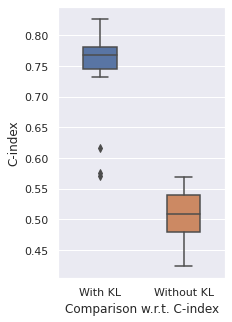

In [228]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list_95)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list_95)

data = np.array(concordance_td_list_95 + concordance_td_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t. C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t. C-index', y='C-index', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)


40

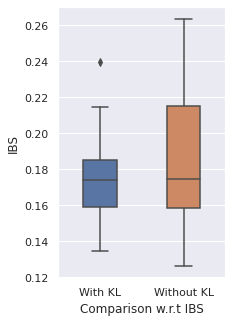

In [229]:
data = np.array(integrated_brier_score_list_95 + integrated_brier_score_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBS": data, "Comparison w.r.t IBS": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBS', y='IBS', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)

In [241]:
class MnistSimInput(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        img = self.mnist_dataset[index]
        return img

labtrans = LogisticHazard.label_transform(20)
target_train = labtrans.fit_transform(*sim_train_subset)

concordance_td_list_90 = []
integrated_brier_score_list_90 = []
integrated_nbll_list_90 = []
concordance_td_list_old = []
integrated_brier_score_list_old = []
# integrated_nbll_list_old = []

ratio = 0.9
for i in range(20):
  print(i)
  list1 = [i for i in range(30000)]
  index_prior = sample(list1, int(30000 * ratio))
  index_local = [i for i in list1 if i not in index_prior]

  img_prior = [img[i] for i in index_prior]
  img_prior = torch.stack(img_prior)

  img_local = [img[i] for i in index_local]
  img_local = torch.stack(img_local)

  sim_prior = (sim_train_subset[0][index_prior], sim_train_subset[1][index_prior])
  sim_local = (sim_train_subset[0][index_local], sim_train_subset[1][index_local])

  list1 = [i for i in range(int(30000 * ratio))]
  index_prior_train = sample(list1, int(30000 * ratio * 0.8))
  index_prior_val = [i for i in list1 if i not in index_prior_train]

  img_prior_train = [img_prior[i] for i in index_prior_train]
  img_prior_train = torch.stack(img_prior_train)

  img_prior_val = [img_prior[i] for i in index_prior_val]
  img_prior_val = torch.stack(img_prior_val)

  sim_prior_train = (sim_prior[0][index_prior_train], sim_prior[1][index_prior_train])
  sim_prior_val = (sim_prior[0][index_prior_val], sim_prior[1][index_prior_val])

  target_prior = labtrans.transform(*sim_prior)
  target_local = labtrans.transform(*sim_local)
  target_prior_train = labtrans.transform(*sim_prior_train)
  target_prior_val = labtrans.transform(*sim_prior_val)

  class MnistSimDatasetBatch(Dataset):
      def __init__(self, mnist_dataset, time, event):
          self.mnist_dataset = mnist_dataset
          self.time, self.event = tt.tuplefy(time, event).to_tensor()

      def __len__(self):
          return len(self.time)

      def __getitem__(self, index):
          if not hasattr(index, '__iter__'):
              index = [index]
          img = [self.mnist_dataset[i] for i in index]
          img = torch.stack(img)
          return tt.tuplefy(img, (self.time[index], self.event[index]))

  data_prior = MnistSimDatasetBatch(img_prior, *target_prior)
  data_local = MnistSimDatasetBatch(img_local, *target_local)
  data_prior_train = MnistSimDatasetBatch(img_prior_train, *target_prior_train)
  data_prior_val = MnistSimDatasetBatch(img_prior_val, *target_prior_val)

  batch_size = 32

  dl_prior = tt.data.DataLoaderBatch(data_prior, batch_size, shuffle=True)
  dl_local = tt.data.DataLoaderBatch(data_local, batch_size, shuffle=False)

  dl_prior_train = tt.data.DataLoaderBatch(data_prior_train, batch_size, shuffle=True)
  dl_prior_val = tt.data.DataLoaderBatch(data_prior_val, batch_size, shuffle=True)

  class Net(nn.Module):
      def __init__(self, out_features):
          super().__init__()
          self.conv1 = nn.Conv2d(1, 16, 5, 1)
          self.max_pool = nn.MaxPool2d(2)
          self.conv2 = nn.Conv2d(16, 16, 5, 1)
          self.glob_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
          self.fc1 = nn.Linear(16, 16)
          self.fc2 = nn.Linear(16, out_features)

      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = self.max_pool(x)
          x = F.relu(self.conv2(x))
          x = self.glob_avg_pool(x)
          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

  net = Net(labtrans.out_features)

  model = LogisticHazard(net, tt.optim.Adam(0.005))

  callbacks = [tt.cb.EarlyStopping(patience=5)]
  epochs = 100
  verbose = False
  log = model.fit_dataloader(dl_prior_train, epochs, callbacks, verbose, val_dataloader=dl_prior_val)

  list1 = [i for i in range(int(30000 * (1 - ratio)))]
  index_local_train = sample(list1, int(30000 * (1 - ratio) * 0.8))
  index_local_test = [i for i in list1 if i not in index_local_train]

  list2 = [i for i in range(int(30000 * (1 - ratio) * 0.8))]
  index_temp = sample(list2, int(30000 * (1 - ratio) * 0.8 * 0.8))
  index_local_val = [index_local_train[i] for i in list2 if i not in index_temp]
  index_local_train = [index_local_train[i] for i in list2 if i in index_temp]

  img_local_train = [img_local[i] for i in index_local_train]
  img_local_train = torch.stack(img_local_train)

  img_local_val = [img_local[i] for i in index_local_val]
  img_local_val = torch.stack(img_local_val)

  img_local_test = [img_local[i] for i in index_local_test]
  img_local_test = torch.stack(img_local_test)

  sim_local_train = (sim_local[0][index_local_train], sim_local[1][index_local_train])
  sim_local_val = (sim_local[0][index_local_val], sim_local[1][index_local_val])
  sim_local_test = (sim_local[0][index_local_test], sim_local[1][index_local_test])

  target_local_train = labtrans.transform(*sim_local_train)
  target_local_val = labtrans.transform(*sim_local_val)
  target_local_test = labtrans.transform(*sim_local_test)

  prior_info_train = model.predict_hazard(img_local_train)
  prior_info_val = model.predict_hazard(img_local_val)

  time = target_local[0]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 21))
  np.put_along_axis(zeros, time, np.array(target_local[1]).reshape(-1, 1), axis=1)
  zeros = zeros[:, :-1]

  zeros_train = zeros[index_local_train]
  zeros_val = zeros[index_local_val]

  eta = 20
  combined_info_train = (torch.Tensor(zeros_train).to("cuda") + eta * prior_info_train) / (1 + eta)
  combined_info_val = (torch.Tensor(zeros_val).to("cuda") + eta * prior_info_val) / (1 + eta)

  target_local_train_new = (combined_info_train, *target_local_train)
  target_local_val_new = (combined_info_val, *target_local_val)

  class MnistSimDatasetBatch(Dataset):
      def __init__(self, mnist_dataset, combined_info, time, event):
          self.mnist_dataset = mnist_dataset
          self.time, self.event = tt.tuplefy(time, event).to_tensor()
          self.combined_info = combined_info

      def __len__(self):
          return len(self.time)

      def __getitem__(self, index):
          if not hasattr(index, '__iter__'):
              index = [index]
          img = [self.mnist_dataset[i] for i in index]
          img = torch.stack(img)
          return tt.tuplefy(img, (self.combined_info[index], self.time[index], self.event[index]))

  data_local_train = MnistSimDatasetBatch(img_local_train, *target_local_train_new)
  data_local_val = MnistSimDatasetBatch(img_local_val, *target_local_val_new)
  # data_local_test = MnistSimDatasetBatch(img_local, *target_local_test)

  batch_size = 32

  dl_local_train = tt.data.DataLoaderBatch(data_local_train, batch_size, shuffle=True)
  dl_local_val = tt.data.DataLoaderBatch(data_local_val, batch_size, shuffle=True)
  # dl_local_test = tt.data.DataLoaderBatch(data_local_test, batch_size, shuffle=True)

  net = Net(labtrans.out_features)

  model = LogisticHazard(net, tt.optim.Adam(0.005), loss = "option")

  callbacks = [tt.cb.EarlyStopping(patience=5)]
  epochs = 50
  verbose = False
  log = model.fit_dataloader(dl_local_train, epochs, callbacks, verbose, val_dataloader=dl_local_val)

  data_local_test = MnistSimInput(img_local_test)
  dl_local_test = DataLoader(data_local_test, batch_size, shuffle=False)

  surv = model.interpolate(20).predict_surv_df(dl_local_test)
  ev = EvalSurv(surv, *target_local_test, 'km')
  concordance_td_list_90.append(ev.concordance_td("antolini"))

  time_grid = np.linspace(0, sim_test[0].max())
  integrated_brier_score_list_90.append(ev.integrated_brier_score(time_grid))

  class MnistSimDatasetBatch(Dataset):
      def __init__(self, mnist_dataset, time, event):
          self.mnist_dataset = mnist_dataset
          self.time, self.event = tt.tuplefy(time, event).to_tensor()

      def __len__(self):
          return len(self.time)

      def __getitem__(self, index):
          if not hasattr(index, '__iter__'):
              index = [index]
          img = [self.mnist_dataset[i] for i in index]
          img = torch.stack(img)
          return tt.tuplefy(img, (self.time[index], self.event[index]))

  data_local_train = MnistSimDatasetBatch(img_local, *target_local_train)
  data_local_val = MnistSimDatasetBatch(img_local, *target_local_val)
  # data_local_test = MnistSimDatasetBatch(img_local, *target_local_test)

  batch_size = 32

  dl_local_train = tt.data.DataLoaderBatch(data_local_train, batch_size, shuffle=True)
  dl_local_val = tt.data.DataLoaderBatch(data_local_val, batch_size, shuffle=True)
  # dl_local_test = tt.data.DataLoaderBatch(data_local_test, batch_size, shuffle=True)

  net = Net(labtrans.out_features)

  model = LogisticHazard(net, tt.optim.Adam(0.005))

  callbacks = [tt.cb.EarlyStopping(patience=5)]
  epochs = 50
  verbose = False
  log = model.fit_dataloader(dl_local_train, epochs, callbacks, verbose, val_dataloader=dl_local_val)

  class MnistSimInput(Dataset):
      def __init__(self, mnist_dataset):
          self.mnist_dataset = mnist_dataset

      def __len__(self):
          return len(self.mnist_dataset)

      def __getitem__(self, index):
          img = self.mnist_dataset[index]
          return img

  data_local_test = MnistSimInput(img_local_test)
  dl_local_test = DataLoader(data_local_test, batch_size, shuffle=False)

  surv = model.interpolate(20).predict_surv_df(dl_local_test)
  ev = EvalSurv(surv, *target_local_test, 'km')
  concordance_td_list_old.append(ev.concordance_td("antolini"))

  time_grid = np.linspace(0, sim_test[0].max())
  integrated_brier_score_list_old.append(ev.integrated_brier_score(time_grid))

0


/usr/local/lib/python3.7/dist-packages/torchtuples/base.py:484: UserWarning: The input from the dataloader is different from
                        the 'input' during trainig. The shapes are different.
  the 'input' during trainig. The shapes are different."""


1
1
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9
1
10
1
11
1
12
1
13
1
14
1
15
1
16
1
17
1
18
1
19
1


40

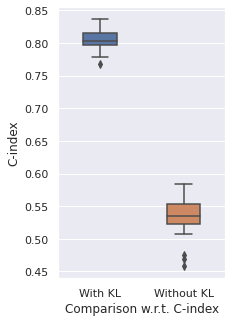

In [242]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list_90)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list_90)

data = np.array(concordance_td_list_90 + concordance_td_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t. C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t. C-index', y='C-index', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)


40

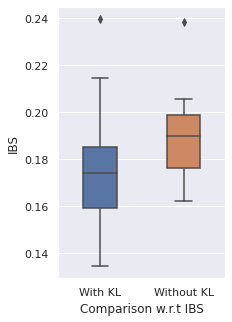

In [243]:
data = np.array(integrated_brier_score_list_90 + integrated_brier_score_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBS": data, "Comparison w.r.t IBS": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBS', y='IBS', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)

In [244]:
class MnistSimInput(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        img = self.mnist_dataset[index]
        return img

labtrans = LogisticHazard.label_transform(20)
target_train = labtrans.fit_transform(*sim_train_subset)

concordance_td_list_80 = []
integrated_brier_score_list_80 = []
integrated_nbll_list_80 = []
concordance_td_list_old = []
integrated_brier_score_list_old = []
# integrated_nbll_list_old = []

ratio = 0.8
for i in range(20):
  print(i)
  list1 = [i for i in range(30000)]
  index_prior = sample(list1, int(30000 * ratio))
  index_local = [i for i in list1 if i not in index_prior]

  img_prior = [img[i] for i in index_prior]
  img_prior = torch.stack(img_prior)

  img_local = [img[i] for i in index_local]
  img_local = torch.stack(img_local)

  sim_prior = (sim_train_subset[0][index_prior], sim_train_subset[1][index_prior])
  sim_local = (sim_train_subset[0][index_local], sim_train_subset[1][index_local])

  list1 = [i for i in range(int(30000 * ratio))]
  index_prior_train = sample(list1, int(30000 * ratio * 0.8))
  index_prior_val = [i for i in list1 if i not in index_prior_train]

  img_prior_train = [img_prior[i] for i in index_prior_train]
  img_prior_train = torch.stack(img_prior_train)

  img_prior_val = [img_prior[i] for i in index_prior_val]
  img_prior_val = torch.stack(img_prior_val)

  sim_prior_train = (sim_prior[0][index_prior_train], sim_prior[1][index_prior_train])
  sim_prior_val = (sim_prior[0][index_prior_val], sim_prior[1][index_prior_val])

  target_prior = labtrans.transform(*sim_prior)
  target_local = labtrans.transform(*sim_local)
  target_prior_train = labtrans.transform(*sim_prior_train)
  target_prior_val = labtrans.transform(*sim_prior_val)

  class MnistSimDatasetBatch(Dataset):
      def __init__(self, mnist_dataset, time, event):
          self.mnist_dataset = mnist_dataset
          self.time, self.event = tt.tuplefy(time, event).to_tensor()

      def __len__(self):
          return len(self.time)

      def __getitem__(self, index):
          if not hasattr(index, '__iter__'):
              index = [index]
          img = [self.mnist_dataset[i] for i in index]
          img = torch.stack(img)
          return tt.tuplefy(img, (self.time[index], self.event[index]))

  data_prior = MnistSimDatasetBatch(img_prior, *target_prior)
  data_local = MnistSimDatasetBatch(img_local, *target_local)
  data_prior_train = MnistSimDatasetBatch(img_prior_train, *target_prior_train)
  data_prior_val = MnistSimDatasetBatch(img_prior_val, *target_prior_val)

  batch_size = 32

  dl_prior = tt.data.DataLoaderBatch(data_prior, batch_size, shuffle=True)
  dl_local = tt.data.DataLoaderBatch(data_local, batch_size, shuffle=False)

  dl_prior_train = tt.data.DataLoaderBatch(data_prior_train, batch_size, shuffle=True)
  dl_prior_val = tt.data.DataLoaderBatch(data_prior_val, batch_size, shuffle=True)

  class Net(nn.Module):
      def __init__(self, out_features):
          super().__init__()
          self.conv1 = nn.Conv2d(1, 16, 5, 1)
          self.max_pool = nn.MaxPool2d(2)
          self.conv2 = nn.Conv2d(16, 16, 5, 1)
          self.glob_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
          self.fc1 = nn.Linear(16, 16)
          self.fc2 = nn.Linear(16, out_features)

      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = self.max_pool(x)
          x = F.relu(self.conv2(x))
          x = self.glob_avg_pool(x)
          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

  net = Net(labtrans.out_features)

  model = LogisticHazard(net, tt.optim.Adam(0.005))

  callbacks = [tt.cb.EarlyStopping(patience=5)]
  epochs = 100
  verbose = False
  log = model.fit_dataloader(dl_prior_train, epochs, callbacks, verbose, val_dataloader=dl_prior_val)

  list1 = [i for i in range(int(30000 * (1 - ratio)))]
  index_local_train = sample(list1, int(30000 * (1 - ratio) * 0.8))
  index_local_test = [i for i in list1 if i not in index_local_train]

  list2 = [i for i in range(int(30000 * (1 - ratio) * 0.8))]
  index_temp = sample(list2, int(30000 * (1 - ratio) * 0.8 * 0.8))
  index_local_val = [index_local_train[i] for i in list2 if i not in index_temp]
  index_local_train = [index_local_train[i] for i in list2 if i in index_temp]

  img_local_train = [img_local[i] for i in index_local_train]
  img_local_train = torch.stack(img_local_train)

  img_local_val = [img_local[i] for i in index_local_val]
  img_local_val = torch.stack(img_local_val)

  img_local_test = [img_local[i] for i in index_local_test]
  img_local_test = torch.stack(img_local_test)

  sim_local_train = (sim_local[0][index_local_train], sim_local[1][index_local_train])
  sim_local_val = (sim_local[0][index_local_val], sim_local[1][index_local_val])
  sim_local_test = (sim_local[0][index_local_test], sim_local[1][index_local_test])

  target_local_train = labtrans.transform(*sim_local_train)
  target_local_val = labtrans.transform(*sim_local_val)
  target_local_test = labtrans.transform(*sim_local_test)

  prior_info_train = model.predict_hazard(img_local_train)
  prior_info_val = model.predict_hazard(img_local_val)

  time = target_local[0]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 21))
  np.put_along_axis(zeros, time, np.array(target_local[1]).reshape(-1, 1), axis=1)
  zeros = zeros[:, :-1]

  zeros_train = zeros[index_local_train]
  zeros_val = zeros[index_local_val]

  eta = 20
  combined_info_train = (torch.Tensor(zeros_train).to("cuda") + eta * prior_info_train) / (1 + eta)
  combined_info_val = (torch.Tensor(zeros_val).to("cuda") + eta * prior_info_val) / (1 + eta)

  target_local_train_new = (combined_info_train, *target_local_train)
  target_local_val_new = (combined_info_val, *target_local_val)

  class MnistSimDatasetBatch(Dataset):
      def __init__(self, mnist_dataset, combined_info, time, event):
          self.mnist_dataset = mnist_dataset
          self.time, self.event = tt.tuplefy(time, event).to_tensor()
          self.combined_info = combined_info

      def __len__(self):
          return len(self.time)

      def __getitem__(self, index):
          if not hasattr(index, '__iter__'):
              index = [index]
          img = [self.mnist_dataset[i] for i in index]
          img = torch.stack(img)
          return tt.tuplefy(img, (self.combined_info[index], self.time[index], self.event[index]))

  data_local_train = MnistSimDatasetBatch(img_local_train, *target_local_train_new)
  data_local_val = MnistSimDatasetBatch(img_local_val, *target_local_val_new)
  # data_local_test = MnistSimDatasetBatch(img_local, *target_local_test)

  batch_size = 32

  dl_local_train = tt.data.DataLoaderBatch(data_local_train, batch_size, shuffle=True)
  dl_local_val = tt.data.DataLoaderBatch(data_local_val, batch_size, shuffle=True)
  # dl_local_test = tt.data.DataLoaderBatch(data_local_test, batch_size, shuffle=True)

  net = Net(labtrans.out_features)

  model = LogisticHazard(net, tt.optim.Adam(0.005), loss = "option")

  callbacks = [tt.cb.EarlyStopping(patience=5)]
  epochs = 50
  verbose = False
  log = model.fit_dataloader(dl_local_train, epochs, callbacks, verbose, val_dataloader=dl_local_val)

  data_local_test = MnistSimInput(img_local_test)
  dl_local_test = DataLoader(data_local_test, batch_size, shuffle=False)

  surv = model.interpolate(20).predict_surv_df(dl_local_test)
  ev = EvalSurv(surv, *target_local_test, 'km')
  concordance_td_list_80.append(ev.concordance_td("antolini"))

  time_grid = np.linspace(0, sim_test[0].max())
  integrated_brier_score_list_80.append(ev.integrated_brier_score(time_grid))

  class MnistSimDatasetBatch(Dataset):
      def __init__(self, mnist_dataset, time, event):
          self.mnist_dataset = mnist_dataset
          self.time, self.event = tt.tuplefy(time, event).to_tensor()

      def __len__(self):
          return len(self.time)

      def __getitem__(self, index):
          if not hasattr(index, '__iter__'):
              index = [index]
          img = [self.mnist_dataset[i] for i in index]
          img = torch.stack(img)
          return tt.tuplefy(img, (self.time[index], self.event[index]))

  data_local_train = MnistSimDatasetBatch(img_local, *target_local_train)
  data_local_val = MnistSimDatasetBatch(img_local, *target_local_val)
  # data_local_test = MnistSimDatasetBatch(img_local, *target_local_test)

  batch_size = 32

  dl_local_train = tt.data.DataLoaderBatch(data_local_train, batch_size, shuffle=True)
  dl_local_val = tt.data.DataLoaderBatch(data_local_val, batch_size, shuffle=True)
  # dl_local_test = tt.data.DataLoaderBatch(data_local_test, batch_size, shuffle=True)

  net = Net(labtrans.out_features)

  model = LogisticHazard(net, tt.optim.Adam(0.005))

  callbacks = [tt.cb.EarlyStopping(patience=5)]
  epochs = 50
  verbose = False
  log = model.fit_dataloader(dl_local_train, epochs, callbacks, verbose, val_dataloader=dl_local_val)

  class MnistSimInput(Dataset):
      def __init__(self, mnist_dataset):
          self.mnist_dataset = mnist_dataset

      def __len__(self):
          return len(self.mnist_dataset)

      def __getitem__(self, index):
          img = self.mnist_dataset[index]
          return img

  data_local_test = MnistSimInput(img_local_test)
  dl_local_test = DataLoader(data_local_test, batch_size, shuffle=False)

  surv = model.interpolate(20).predict_surv_df(dl_local_test)
  ev = EvalSurv(surv, *target_local_test, 'km')
  concordance_td_list_old.append(ev.concordance_td("antolini"))

  time_grid = np.linspace(0, sim_test[0].max())
  integrated_brier_score_list_old.append(ev.integrated_brier_score(time_grid))

0


/usr/local/lib/python3.7/dist-packages/torchtuples/base.py:484: UserWarning: The input from the dataloader is different from
                        the 'input' during trainig. The shapes are different.
  the 'input' during trainig. The shapes are different."""


1
1
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9
1
10
1
11
1
12
1
13
1
14
1
15
1
16
1
17
1
18
1
19
1


40

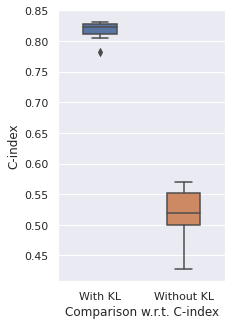

In [245]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list_80)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list_80)

data = np.array(concordance_td_list_80 + concordance_td_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t. C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t. C-index', y='C-index', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)


40

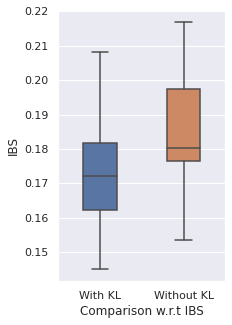

In [246]:
data = np.array(integrated_brier_score_list_80 + integrated_brier_score_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBS": data, "Comparison w.r.t IBS": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBS', y='IBS', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)

80

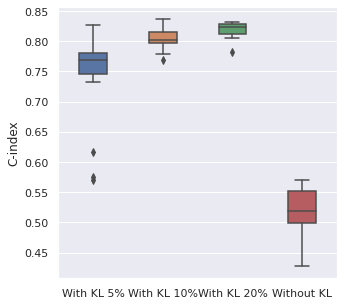

In [248]:
import seaborn as sns

# Creating plot
concordance_td_array = np.array(concordance_td_list_95)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list_95)

data = np.array(concordance_td_list_95 + concordance_td_list_90 + concordance_td_list_80 + concordance_td_list_old)
label = ["With KL 5%" for i in range(len(concordance_td_array))] + ["With KL 10%" for i in range(len(concordance_td_array))] + ["With KL 20%" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t. C-index": label})

sns.set(rc={'figure.figsize':(5,5)})
sns.boxplot(x='Comparison w.r.t. C-index', y='C-index', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")
len(data)


80

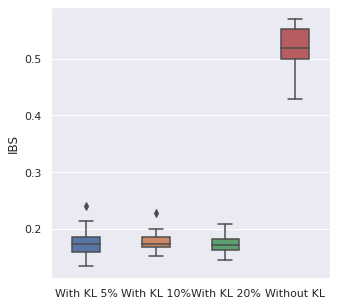

In [250]:
data = np.array(integrated_brier_score_list_95 + integrated_brier_score_list_90 + integrated_brier_score_list_80 + concordance_td_list_old)
label = ["With KL 5%" for i in range(len(concordance_td_array))] + ["With KL 10%" for i in range(len(concordance_td_array))] + ["With KL 20%" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBS": data, "Comparison w.r.t. IBS": label})

sns.set(rc={'figure.figsize':(5,5)})
sns.boxplot(x='Comparison w.r.t. IBS', y='IBS', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")
len(data)
